In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from fastai.vision.gan import *
from PIL import Image

import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import pdb
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.autograd import Variable
from torchvision.utils import save_image
import torch.autograd as autograd

In [2]:
import math
import torch
from torch.optim.optimizer import Optimizer, required
import itertools as it
#from torch.optim import Optimizer
#credit - Lookahead implementation from LonePatient - https://github.com/lonePatient/lookahead_pytorch/blob/master/optimizer.py
#credit2 - RAdam code by https://github.com/LiyuanLucasLiu/RAdam/blob/master/radam.py


class Ranger(Optimizer):
    
    def __init__(self, params, lr=1e-4, alpha=0.5, k=6, betas=(.9,0.999), eps=1e-8, weight_decay=0):
        #parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')
        
        #prep defaults and init torch.optim base
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params,defaults)
        
        #now we can get to work...
        for group in self.param_groups:
            group["step_counter"] = 0
            #print("group step counter init")
                      
        #look ahead params
        self.alpha = alpha
        self.k = k 
        
        #radam buffer for state
        self.radam_buffer = [[None,None,None] for ind in range(10)]
        
        #lookahead weights
        self.slow_weights = [[p.clone().detach() for p in group['params']]
                                for group in self.param_groups]
        
        #don't use grad for lookahead weights
        for w in it.chain(*self.slow_weights):
            w.requires_grad = False
        
    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)
       
        
    def step(self, closure=None):
        loss = None
        #note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.  
        #Uncomment if you need to use the actual closure...
        
        #if closure is not None:
            #loss = closure()
            
        #------------ radam
        for group in self.param_groups:
    
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')
    
                p_data_fp32 = p.data.float()
    
                state = self.state[p]
    
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)
    
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
    
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
    
                state['step'] += 1
                buffered = self.radam_buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size
    
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
    
                if N_sma > 5:                    
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)
    
                p.data.copy_(p_data_fp32)
        
        
        #---------------- end radam step
        
        #look ahead tracking and updating if latest batch = k
        for group,slow_weights in zip(self.param_groups,self.slow_weights):
            group['step_counter'] += 1
            if group['step_counter'] % self.k != 0:
                continue
            for p,q in zip(group['params'],slow_weights):
                if p.grad is None:
                    continue
                q.data.add_(self.alpha,p.data - q.data)
                p.data.copy_(q.data)
            
        
            
        return loss

In [3]:
#Dogs path = Path()/'data'/'Images'
path = untar_data(URLs.LSUN_BEDROOMS)
BATCH_SIZE = 64

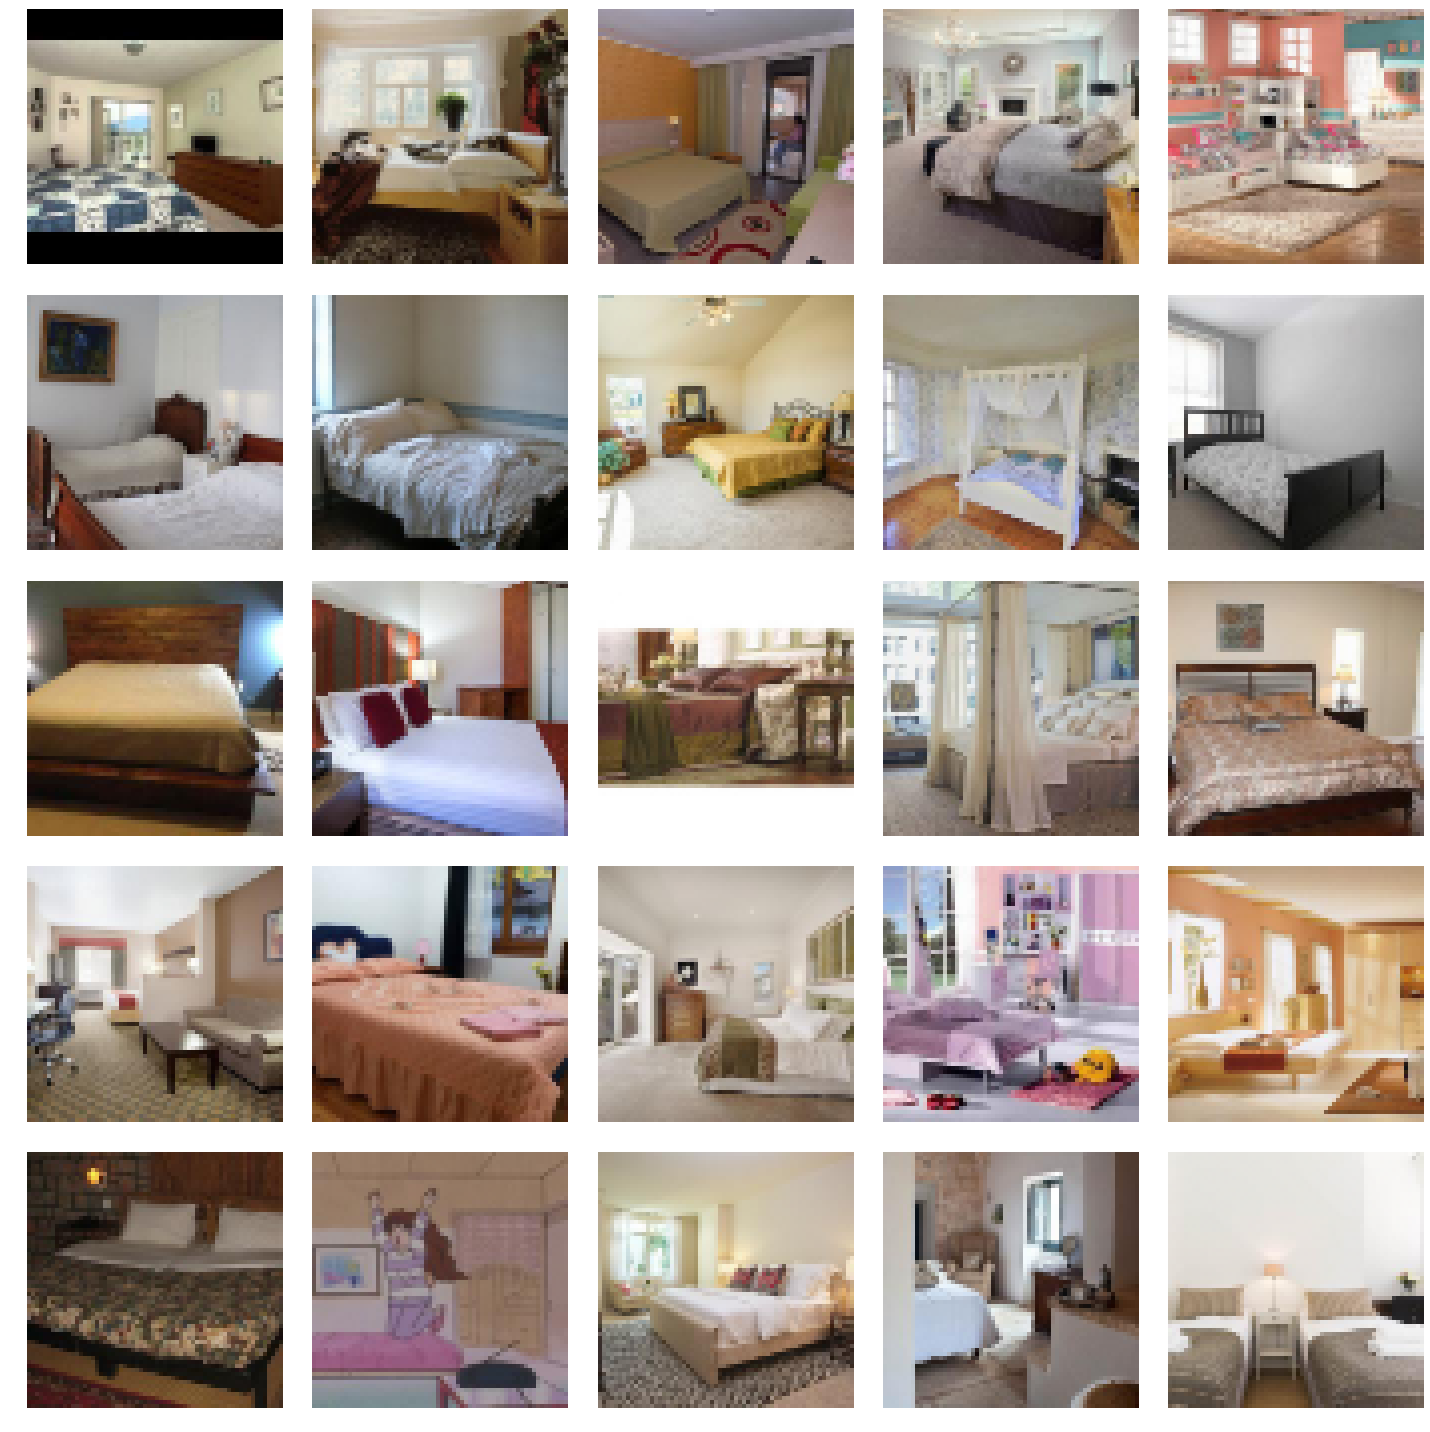

In [4]:
import fastai.vision.image as im
def get_data(bs, size):
    return (GANItemList.from_folder(path, noise_sz=128)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))
data = get_data(BATCH_SIZE, 64)
data.show_batch()

In [5]:
data

ImageDataBunch;

Train: LabelList (303125 items)
x: GANItemList
,,,,
y: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
Path: /home/jupyter/.fastai/data/bedroom;

Valid: LabelList (0 items)
x: GANItemList

y: ImageList

Path: /home/jupyter/.fastai/data/bedroom;

Test: None

# Spectral Norm

In [ ]:
# ResNet generator and discriminator
w_g=4
channels=3
leak = 0.1
from torch.nn.utils import weight_norm, spectral_norm
class ResBlockGenerator(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlockGenerator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding=1)
        nn.init.xavier_uniform(self.conv1.weight.data, 1.)
        nn.init.xavier_uniform(self.conv2.weight.data, 1.)

        self.model = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            torch.nn.utils.spectral_norm(self.conv1),
            nn.ReLU(),
            torch.nn.utils.spectral_norm(self.conv2),
            nn.ReLU(),
            )
        self.bypass = nn.Sequential()
        if stride != 1:
            self.bypass = nn.Upsample(scale_factor=2)

    def forward(self, x):
        return self.model(x) + self.bypass(x)


class ResBlockDiscriminator(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlockDiscriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding=1)
        nn.init.xavier_uniform(self.conv1.weight.data, 1.)
        nn.init.xavier_uniform(self.conv2.weight.data, 1.)

        if stride == 1:
            self.model = nn.Sequential(
                nn.ReLU(),
                torch.nn.utils.spectral_norm(self.conv1),
                nn.ReLU(),
                torch.nn.utils.spectral_norm(self.conv2)
                )
        else:
            self.model = nn.Sequential(
                nn.ReLU(),
                torch.nn.utils.spectral_norm(self.conv1),
                nn.ReLU(),
                torch.nn.utils.spectral_norm(self.conv2),
                nn.AvgPool2d(2, stride=stride, padding=0)
                )
        self.bypass = nn.Sequential()
        if stride != 1:

            self.bypass_conv = nn.Conv2d(in_channels,out_channels, 1, 1, padding=0)
            nn.init.xavier_uniform(self.bypass_conv.weight.data, np.sqrt(2))

            self.bypass = nn.Sequential(
                torch.nn.utils.spectral_norm(self.bypass_conv),
                nn.AvgPool2d(2, stride=stride, padding=0)
            )
            # if in_channels == out_channels:
            #     self.bypass = nn.AvgPool2d(2, stride=stride, padding=0)
            # else:
            #     self.bypass = nn.Sequential(
            #         SpectralNorm(nn.Conv2d(in_channels,out_channels, 1, 1, padding=0)),
            #         nn.AvgPool2d(2, stride=stride, padding=0)
            #     )


    def forward(self, x):
        return self.model(x) + self.bypass(x)

# special ResBlock just for the first layer of the discriminator
class FirstResBlockDiscriminator(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(FirstResBlockDiscriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding=1)
        self.bypass_conv = nn.Conv2d(in_channels, out_channels, 1, 1, padding=0)
        nn.init.xavier_uniform(self.conv1.weight.data, 1.)
        nn.init.xavier_uniform(self.conv2.weight.data, 1.)
        nn.init.xavier_uniform(self.bypass_conv.weight.data, np.sqrt(2))

        # we don't want to apply ReLU activation to raw image before convolution transformation.
        self.model = nn.Sequential(
            torch.nn.utils.spectral_norm(self.conv1),
            nn.ReLU(),
            torch.nn.utils.spectral_norm(self.conv2),
            nn.AvgPool2d(2)
            )
        self.bypass = nn.Sequential(
            nn.AvgPool2d(2),
            torch.nn.utils.spectral_norm(self.bypass_conv),
        )

    def forward(self, x):
        return self.model(x) + self.bypass(x)

GEN_SIZE=128
DISC_SIZE=128

class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.dense = nn.Linear(self.z_dim, 4 * 4 * GEN_SIZE)
        self.final = nn.Conv2d(GEN_SIZE, channels, 3, stride=1, padding=1)
        nn.init.xavier_uniform(self.dense.weight.data, 1.)
        nn.init.xavier_uniform(self.final.weight.data, 1.)

        self.model = nn.Sequential(
            ResBlockGenerator(GEN_SIZE, GEN_SIZE, stride=2),
            ResBlockGenerator(GEN_SIZE, GEN_SIZE, stride=2),
            ResBlockGenerator(GEN_SIZE, GEN_SIZE, stride=2))
        
        self.lastLayer = ResBlockGenerator(GEN_SIZE, GEN_SIZE, stride=2)
        
        self.final = nn.Sequential(
            nn.BatchNorm2d(GEN_SIZE),
            nn.ReLU(),
            self.final,
            nn.Tanh())

    def forward(self, z):
        z = z.squeeze(-1).squeeze(-1)
        return self.final(self.lastLayer(self.model(self.dense(z).view(-1, GEN_SIZE, 4, 4))))

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()

        self.model = nn.Sequential(
                FirstResBlockDiscriminator(channels, DISC_SIZE, stride=2),
                ResBlockDiscriminator(DISC_SIZE, DISC_SIZE, stride=2),
                ResBlockDiscriminator(DISC_SIZE, DISC_SIZE),
                ResBlockDiscriminator(DISC_SIZE, DISC_SIZE),
                nn.ReLU(),
                nn.AvgPool2d(8),
            )
        self.fc = nn.Linear(DISC_SIZE, 1)
        nn.init.xavier_uniform(self.fc.weight.data, 1.)
        self.fc = torch.nn.utils.spectral_norm(self.fc)

    def forward(self, x):
        return self.fc(self.model(x).view(-1,DISC_SIZE))

# GAN Wrapper

In [ ]:
class GANLearner(Learner):
    "A `Learner` suitable for GANs."
    def __init__(self, data:DataBunch, generator:nn.Module, critic:nn.Module, gen_loss_func:LossFunction,
                 crit_loss_func:LossFunction, switcher:Callback=None, gen_first:bool=False, switch_eval:bool=True,
                 show_img:bool=True, clip:float=None, **learn_kwargs):
        gan = GANModule(generator, critic)
        loss_func = GANLoss(gen_loss_func, crit_loss_func, gan)
        switcher = ifnone(switcher, partial(FixedGANSwitcher, n_crit=5, n_gen=1))
        super().__init__(data, gan, loss_func=loss_func, callback_fns=[switcher], **learn_kwargs)
        trainer = GANTrainer(self, clip=clip, switch_eval=switch_eval, show_img=show_img)
        self.gan_trainer = trainer
        self.callbacks.append(trainer)

class GANModule(nn.Module):
    "Wrapper around a `generator` and a `critic` to create a GAN."
    def __init__(self, generator:nn.Module=None, critic:nn.Module=None, gen_mode:bool=False):
        super().__init__()
        self.gen_mode = gen_mode
        if generator: self.generator,self.critic = generator,critic

    def forward(self, *args):
        return self.generator(*args) if self.gen_mode else self.critic(*args)

    def switch(self, gen_mode:bool=None):
        "Put the model in generator mode if `gen_mode`, in critic mode otherwise."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode
        
class GANLoss(GANModule):
    "Wrapper around `loss_funcC` (for the critic) and `loss_funcG` (for the generator)."
    def __init__(self, loss_funcG:Callable, loss_funcC:Callable, gan_model:GANModule):
        super().__init__()
        self.loss_funcG,self.loss_funcC,self.gan_model = loss_funcG,loss_funcC,gan_model

    def generator(self, output, target):
        "Evaluate the `output` with the critic then uses `self.loss_funcG` to combine it with `target`."
        fake_pred = self.gan_model.critic(output)
        return self.loss_funcG(fake_pred, target, output)

    def critic(self, real_pred, input):

        "Create some `fake_pred` with the generator from `input` and compare them to `real_pred` in `self.loss_funcD`."
        fake = self.gan_model.generator(input.requires_grad_(False)).requires_grad_(True)
        fake_pred = self.gan_model.critic(fake)
        return self.loss_funcC(real_pred, fake_pred)

class GANTrainer(LearnerCallback):
    "Handles GAN Training."
    _order=-20
    def __init__(self, learn:Learner, switch_eval:bool=False, clip:float=None, beta:float=0.98, gen_first:bool=False,
                 show_img:bool=True):
        super().__init__(learn)
        self.switch_eval,self.clip,self.beta,self.gen_first,self.show_img = switch_eval,clip,beta,gen_first,show_img
        self.generator,self.critic = self.model.generator,self.model.critic

    def _set_trainable(self):
        train_model = self.generator if     self.gen_mode else self.critic
        loss_model  = self.generator if not self.gen_mode else self.critic
        requires_grad(train_model, True)
        requires_grad(loss_model, False)
        if self.switch_eval:
            train_model.train()
            loss_model.eval()

    def on_train_begin(self, **kwargs):
        "Create the optimizers for the generator and critic if necessary, initialize smootheners."
        if not getattr(self,'opt_gen',None):
            self.opt_gen = self.opt.new([nn.Sequential(*flatten_model(self.generator))])
        else: self.opt_gen.lr,self.opt_gen.wd = self.opt.lr,self.opt.wd
        if not getattr(self,'opt_critic',None):
            self.opt_critic = self.opt.new([nn.Sequential(*flatten_model(self.critic))])
        else: self.opt_critic.lr,self.opt_critic.wd = self.opt.lr,self.opt.wd
        self.gen_mode = self.gen_first
        self.switch(self.gen_mode)
        self.closses,self.glosses = [],[]
        self.smoothenerG,self.smoothenerC = SmoothenValue(self.beta),SmoothenValue(self.beta)
        #self.recorder.no_val=True
        self.recorder.add_metric_names(['gen_loss', 'disc_loss'])
        self.imgs,self.titles = [],[]

    def on_train_end(self, **kwargs):
        "Switch in generator mode for showing results."
        self.switch(gen_mode=True)

    def on_batch_begin(self, last_input, last_target, **kwargs):
        "Clamp the weights with `self.clip` if it's not None, return the correct input."
        if self.clip is not None:
            for p in self.critic.parameters(): p.data.clamp_(-self.clip, self.clip)
        return {'last_input':last_input,'last_target':last_target} if self.gen_mode else {'last_input':last_target,'last_target':last_input}

    def on_backward_begin(self, last_loss, last_output, **kwargs):
        "Record `last_loss` in the proper list."
        last_loss = last_loss.detach().cpu()
        if self.gen_mode:
            self.smoothenerG.add_value(last_loss)
            self.glosses.append(self.smoothenerG.smooth)
            self.last_gen = last_output.detach().cpu()
        else:
            self.smoothenerC.add_value(last_loss)
            self.closses.append(self.smoothenerC.smooth)

    def on_epoch_begin(self, epoch, **kwargs):
        "Put the critic or the generator back to eval if necessary."
        self.switch(self.gen_mode)

    def on_epoch_end(self, pbar, epoch, last_metrics, **kwargs):
        "Put the various losses in the recorder and show a sample image."
        self.opt.lr = self.opt.lr * 0.99
        #print(self.opt.lr)
        if not hasattr(self, 'last_gen') or not self.show_img: return
        data = self.learn.data
        img = self.last_gen[0]
        norm = getattr(data,'norm',False)
        if norm and norm.keywords.get('do_y',False): img = data.denorm(img)
        img = data.train_ds.y.reconstruct(img)
        self.imgs.append(img)
        self.titles.append(f'Epoch {epoch}')
        pbar.show_imgs(self.imgs, self.titles)
        return add_metrics(last_metrics, [getattr(self.smoothenerG,'smooth',None),getattr(self.smoothenerC,'smooth',None)])

    def switch(self, gen_mode:bool=None):
        "Switch the model, if `gen_mode` is provided, in the desired mode."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode
        self.opt.opt = self.opt_gen.opt if self.gen_mode else self.opt_critic.opt
        self._set_trainable()
        self.model.switch(gen_mode)
        self.loss_func.switch(gen_mode)

class FixedGANSwitcher(LearnerCallback):
    "Switcher to do `n_crit` iterations of the critic then `n_gen` iterations of the generator."
    def __init__(self, learn:Learner, n_crit=3, n_gen=1):
        super().__init__(learn)
        self.n_crit,self.n_gen = 5,1

    def on_train_begin(self, **kwargs):
        "Initiate the iteration counts."
        self.n_c,self.n_g = 0,0

    def on_batch_end(self, iteration, **kwargs):
        "Switch the model if necessary."
        if self.learn.gan_trainer.gen_mode:
            self.n_g += 1
            n_iter,n_in,n_out = self.n_gen,self.n_c,self.n_g
        else:
            self.n_c += 1
            n_iter,n_in,n_out = self.n_crit,self.n_g,self.n_c
        target = n_iter if isinstance(n_iter, int) else n_iter(n_in)
        if target == n_out:
            self.learn.gan_trainer.switch()
            self.n_c,self.n_g = 0,0

# Loss

In [ ]:
#nn.ReLU()(1.0 - discriminator(data)).mean() + nn.ReLU()(1.0 + discriminator(generator(z))).mean()
class ModNoopLoss(nn.Module):
    "Just returns the mean of the `output`."
    def forward(self, output, *args): return -output.mean()

class ModWassersteinLoss(nn.Module):
    "For WGAN."
    def forward(self, real, fake): 
        return nn.ReLU()(1.0-real).mean() + nn.ReLU()(1+fake).mean() 

# Ranger

In [ ]:
optar = partial(Ranger)

# Training

In [ ]:
generator = Generator(128)
critic = Critic()

wgan = GANLearner(data, generator, critic, gen_loss_func=ModNoopLoss(), crit_loss_func=ModWassersteinLoss(),switch_eval=False,
                        opt_func = optar, wd=0.)

In [ ]:
wgan.fit(500, 1.29e-4)

In [ ]:
wgan.save('beds=specnorm-ranger-50e')

# Testing 

In [ ]:
wgan.show_results(ds_type=DatasetType.Train, rows=16, figsize=(16,16))